In [30]:
import preprocessing as pp
import sampling
import random
import torch
from models import graphClassifier, nodeClassifier
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2.csv"



nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))

# create the graphs for both networks
G_nerve = pp.createGraph(nodes_n, edges_n, index_addon ="n")
G_lymph = pp.createGraph(nodes_l, edges_l, index_addon ="l")

# get short description of graph
pp.graphSummary(G_nerve)
pp.graphSummary(G_lymph)

# get rid of self-loops, multi edges and isolated nodes
G_nerve_einf = pp.convertToEinfach(G_nerve)
G_lymph_einf = pp.convertToEinfach(G_lymph)

# enrich the attributes of the nodes with information from the incident edges
pp.enrichNodeAttributes(G_lymph_einf)
pp.enrichNodeAttributes(G_nerve_einf)


***************
Number of Nodes: 4317
Number of Edges: 6634
Number of Connected Components: 22
Number of Self Loops: 528
Number of Isolated Nodes: 0
Average Node Degree: 3.073430623117906
***************
***************
Number of Nodes: 3036
Number of Edges: 3864
Number of Connected Components: 89
Number of Self Loops: 25
Number of Isolated Nodes: 1
Average Node Degree: 2.5454545454545454
***************


# Graph Classification using Subsets of Lymph and Nerve Network for Training and Testing

In [3]:

# create random samples 
randomSampleLymphNx, randomSampleLymph = sampling.randomGeomSubgraphs(G_lymph_einf, label = 1,starts = 100, node_sample_size = 100,  mode = "rnn")
randomSampleNerveNx, randomSampleNerve = sampling.randomGeomSubgraphs(G_nerve_einf, label = 0,starts = 100, node_sample_size = 100,  mode = "rnn")

# combine the graphs to a random set
allGraphs = randomSampleLymph + randomSampleNerve
random.shuffle(allGraphs)

# split into training and test set
breaker = int(len(allGraphs)*0.8)
train_dataset = allGraphs[:breaker]
test_dataset = allGraphs[breaker:]

Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 552.03it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 191.56it/s]


In [4]:
# selection of the features to use
feat_slice = [1,3,7,8]

# create the model
model = graphClassifier.GCN_GC(hidden_channels=32, in_features = len(feat_slice), classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# create brach data loaders for training and test set
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



def train_GC():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test_GC(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



for epoch in range(1, 11):
    train_GC()
    train_acc = test_GC(train_loader)
    test_acc = test_GC(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



# good features: 1,3 - both features that have to do with length                performance is best if just these 2 features are used
# good features: 7,8 - both features that have to do with distance
# medium features: 6 - num Voxels
# medium features: 4 - curveness
# trash feature: 0,2 - both features that have to do with minRadiusAvg
# trash feature: 5 - avgRadiusStd



# 16 hidden layers seems favorable compared to 64 or 8

# slice = [1,3,7,8] leads to very good results
# slice = [1,3] results are equal to 1,3,7,8 ... maybe better

Epoch: 001, Train Acc: 0.8472, Test Acc: 0.8919
Epoch: 002, Train Acc: 0.7292, Test Acc: 0.7838
Epoch: 003, Train Acc: 0.7986, Test Acc: 0.8108
Epoch: 004, Train Acc: 0.6806, Test Acc: 0.7297
Epoch: 005, Train Acc: 0.8819, Test Acc: 0.9189
Epoch: 006, Train Acc: 0.8958, Test Acc: 0.9189
Epoch: 007, Train Acc: 0.8333, Test Acc: 0.8649
Epoch: 008, Train Acc: 0.9236, Test Acc: 0.9459
Epoch: 009, Train Acc: 0.9028, Test Acc: 0.9730
Epoch: 010, Train Acc: 0.8750, Test Acc: 0.8919


# Node Classification using a contracted graph by spatial proximity to differentiate 3 node types (nerve, lymph, connected)

In [5]:
#rename the nodes to have unqiue identifiers for different types
# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


In [6]:
from scipy.spatial import KDTree
from scipy.sparse import csr_matrix
from scipy.sparse import dok_array
from scipy.sparse.csgraph import connected_components

# create an adjacency matrix for nodes from two node sets that are closer than a given distance
adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)

# find the connected components in the adjacency matrix (nodes that will be merged)
num, labels = connected_components(csgraph=adjMcsr, directed = False)

#create a dict where each new node contains all the nodes that will be merged into it
con_comp = pp.connected_components_dict(labels)

#take only the connected components that contain > 1 element, otherwise no merge is necessary 
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l"))



reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k



In [14]:
merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )

# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)


# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)


# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]


# create a new graph based on the old information
G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf = pp.convertToEinfach(G_contract, self_loops = False, isolates = False)
pp.enrichNodeAttributes(G_contract_einf)

In [15]:
# create the ground truth for the node class
all_nodes = list(G_contract_einf.nodes)
nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


# create the training and testing masks
train_mask = np.random.choice(np.arange(0, len(class_assign)), size= int(len(class_assign)*0.8), replace = False)
test_mask = np.delete(np.arange(0, len(class_assign)), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)

np.random.seed(1234567)
unique, counts = np.unique(class_assign[train_mask], return_counts=True)
print("Train-Mask Class Distribution: ")
print(unique)
print(counts)

print("Test-Mask Class Distribution: ")
unique, counts = np.unique(class_assign[test_mask], return_counts=True)
print(unique)
print(counts)


# convert the graph to a networkx graph

from torch_geometric.utils.convert import from_networkx
networkXG = from_networkx(G_contract_einf)
networkXG.y = torch.tensor(class_assign)


Train-Mask Class Distribution: 
[0 1 2]
[3204 2269  155]
Test-Mask Class Distribution: 
[0 1 2]
[843 528  37]


In [16]:
num_feat = networkXG.x.shape[1]
num_class = len(np.unique(networkXG.y))
netGCN = nodeClassifier.GCN_NC
netSAGE = nodeClassifier.SAGE_NC
netWC = nodeClassifier.WC_NC

optimizer = torch.optim.Adam
criterion = torch.nn.CrossEntropyLoss
modelGCN = nodeClassifier.nodeClassifier(netGCN, hidden_channels=32, features = np.arange(num_feat),classes = num_class, optimizer = optimizer, lossFunc = criterion)
modelSAGE = nodeClassifier.nodeClassifier(netSAGE, hidden_channels=32, features = np.arange(num_feat),classes = num_class, optimizer = optimizer, lossFunc = criterion)
modelWC = nodeClassifier.nodeClassifier(netWC, hidden_channels=32, features = np.arange(num_feat),classes = num_class, optimizer = optimizer, lossFunc = criterion)

models = [modelGCN, modelSAGE, modelWC]
models = [modelSAGE]


epochs = 200
loss_l = np.zeros((epochs, len(models)))
acc_l = np.zeros((epochs, len(models)))
for epoch in range(1, epochs +1):
      for i, model in enumerate(models):
            loss = model.train(networkXG, train_mask)
            loss_l[epoch-1, i] = loss.detach().numpy().copy()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            test_acc = model.test(networkXG, test_mask)
            acc_l[epoch-1, i] = test_acc

for model in models:
      test_acc = model.test(networkXG, test_mask)
      print(f'Test Accuracy: {test_acc:.4f}')

#100 iter:
#13: 58.75%       trash
#12: 58.75%       trash
#11: 62.03%
#10: 69.11 %
#9:  58.75 %      trash
#8:  78.69 %
#7:  78.40 %
#6:  81.08 %
#5:  58.75 %      trash
#4:  68.69 %
#3:  79.97 %
#2:  58.75 %      trash
#1:  79.97 %
#0:  58.75 %      trash

#all:        82.56 %
#no trash:   81.11 %
# >75:       81.96 %
#[1,6,8,10]: 80.77 %

#500 iter:
#all:        82.56 %


Epoch: 001, Loss: 3.6229
Epoch: 002, Loss: 2.2790
Epoch: 003, Loss: 1.6174
Epoch: 004, Loss: 1.2768
Epoch: 005, Loss: 1.1166
Epoch: 006, Loss: 1.2516
Epoch: 007, Loss: 1.2106
Epoch: 008, Loss: 1.0975
Epoch: 009, Loss: 0.9884
Epoch: 010, Loss: 0.9421
Epoch: 011, Loss: 0.9283
Epoch: 012, Loss: 0.8915
Epoch: 013, Loss: 0.8778
Epoch: 014, Loss: 0.8552
Epoch: 015, Loss: 0.8551
Epoch: 016, Loss: 0.8401
Epoch: 017, Loss: 0.8377
Epoch: 018, Loss: 0.8386
Epoch: 019, Loss: 0.8379
Epoch: 020, Loss: 0.8368
Epoch: 021, Loss: 0.8322
Epoch: 022, Loss: 0.8262
Epoch: 023, Loss: 0.8187
Epoch: 024, Loss: 0.8186
Epoch: 025, Loss: 0.8104
Epoch: 026, Loss: 0.8109
Epoch: 027, Loss: 0.8076
Epoch: 028, Loss: 0.8064
Epoch: 029, Loss: 0.8028
Epoch: 030, Loss: 0.8064
Epoch: 031, Loss: 0.7998
Epoch: 032, Loss: 0.7938
Epoch: 033, Loss: 0.7922
Epoch: 034, Loss: 0.7792
Epoch: 035, Loss: 0.7713
Epoch: 036, Loss: 0.7703
Epoch: 037, Loss: 0.7578
Epoch: 038, Loss: 0.7535
Epoch: 039, Loss: 0.7375
Epoch: 040, Loss: 0.7364


In [17]:
import networkx as nx
import pyvista
from visualization import graph_to_mesh
import trimesh

def classifiedGraph(G,pred_mask, test_mask):
    corr = np.where(pred_mask>0)[0]
    wrong = np.where(pred_mask==0)[0]

    corr_nodes = np.array(G.nodes)[test_mask][corr]
    wrong_nodes = np.array(G.nodes)[test_mask][wrong]

    wrong_dict = dict(zip(corr_nodes, [elem + "r" for elem in corr_nodes]))
    right_dict = dict(zip(wrong_nodes, [elem + "f" for elem in wrong_nodes]))

    G_class = nx.relabel_nodes(G, wrong_dict)
    G_class = nx.relabel_nodes(G_class, right_dict)

    return G_class


test_mask_np = test_mask.detach().numpy()
train_mask_np = train_mask.detach().numpy()


pred_mask = modelGCN.predictions(networkXG, test_mask_np)
G_class = classifiedGraph(G_contract_einf, pred_mask, test_mask)

nodeMeshesTrain, unique_nodesTrain = graph_to_mesh.nodeMeshesNx(G_class, concat = True, mask = train_mask_np)
nodeMeshesTest, unique_nodesTest = graph_to_mesh.nodeMeshesNx(G_class, concat = False, mask = test_mask_np)
edgeMeshes, unique_edges = graph_to_mesh.edgeMeshesNx(G_class, concat = True)

print(unique_nodesTrain)
print(unique_nodesTest)
print(unique_edges)


Creating 3061 edges:  50%|█████     | 1537/3061 [00:00<00:00, 5140.12it/s]/home/laurin/Documents/network-eval/visualization/graph_to_mesh.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
/home/laurin/Documents/network-eval/visualization/graph_to_mesh.py:22: RuntimeWarning: invalid value encountered in multiply
  rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
Creating 31 edges: 100%|██████████| 31/31 [00:00<00:00, 3421.94it/s]

['c' 'l' 'n']
['f' 'r']
[['l', 'r'], ['l', 'l'], ['r', 'r'], ['l', 'c'], ['l', 'f'], ['r', 'f'], ['r', 'c'], ['n', 'f'], ['n', 'n'], ['f', 'f'], ['n', 'c'], ['f', 'c'], ['c', 'c']]


In [12]:
node_color_dict = dict(zip(['c', 'f', 'n', 'r', 'l'],["blue", "red", "hotpink", "green", "yellow"]))


plotter = pyvista.Plotter(off_screen = True)


edge_actors = []
for i in range(len(edgeMeshes)):
    mesh = pyvista.wrap(edgeMeshes[i])
    actor = plotter.add_mesh(mesh, color = "beige")
    edge_actors.append(actor)
print("Edges Done!")



node_train_actors = []
for i in range(len(nodeMeshesTrain)):
    color = node_color_dict[unique_nodesTrain[i]]
    mesh = pyvista.wrap(nodeMeshesTrain[i])
    actor = plotter.add_mesh(mesh, color = color)
    node_train_actors.append(actor)
print("Train Nodes Done!")




node_test_actors =[]
for i in range(len(nodeMeshesTest)):
    color = node_color_dict[unique_nodesTest[i]]
    med_actors=[]
    for mesh in nodeMeshesTest[i]:
        mesh = trimesh.base.Trimesh(vertices=mesh.vertices, faces=mesh.faces, face_normals=mesh.face_normals, vertex_normals=mesh.vertex_normals)
        meshW = pyvista.wrap(mesh)
        actor = plotter.add_mesh(meshW, color = color)
        med_actors.append(actor)
    node_test_actors.append(med_actors)
print("Test Nodes Done!")



Edges Done!
Train Nodes Done!
Test Nodes Done!


In [18]:
plotter.window_size = 2000,2000
plotter.camera.position = (5.0, 5.0, -1.5)
plotter.focal_point= (2.0, 1.0,0)
plotter.camera.zoom(1.0)
plotter.add_text("Epoch: 200")
plotter.save_graphic("save_running_test.pdf")

In [ ]:
p = node_actors[3][0].GetProperty()
print(p)

vtkOpenGLProperty (0x4d5a4b00)
  Debug: Off
  Modified Time: 6658888
  Reference Count: 2
  Registered Events: (none)
  Ambient: 0
  Ambient Color: (0, 0.501961, 0)
  Diffuse: 1
  Diffuse Color: (0, 0.501961, 0)
  Edge Color: (0, 0, 0)
  Edge Visibility: Off
  Vertex Color: (1, 0, 0)
  Vertex Visibility: Off
  Interpolation: VTK_FLAT
  Opacity: 1
  Representation: VTK_SURFACE
  Specular: 0
  Specular Color: (0, 0.501961, 0)
  Specular Power: 100
  Backface Culling: Off
  Frontface Culling: Off
  Point size: 5
  Line width: 1
  Line stipple pattern: 65535
  Line stipple repeat factor: 1
  Lighting: On
  RenderPointsAsSpheres: Off
  RenderLinesAsTubes: Off
  Shading: Off
  MaterialName: (none)
  Color: (0, 0.501961, 0)
  EmissiveFactor: (1, 1, 1)
  NormalScale: 1
  OcclusionStrength: 1
  Metallic: 0
  Roughness: 0.5




In [ ]:
for node in node_actors[3]:
    prop = node.GetProperty()
    prop.SetColor((0,0,1))
plotter.save_graphic("save_running_test.pdf")

In [ ]:
#plotter.remove_actor(actor)
#plotter.save_graphic("save_running_test.pdf")

for act_list in node_actors:
    for act in act_list:
        #act.GetProperty().SetColor((0.5,0.5,0.5))
    
plotter.save_graphic("save_running_test.pdf")




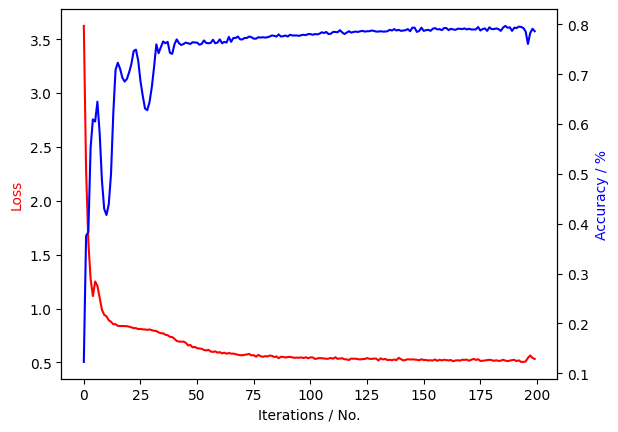

In [19]:
# all SAGE
#loss_l_np = [elem.detach().numpy() for elem in loss_l]
for i in range(len(models)):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loss_l[:,i], color = "red")
    ax2.plot(acc_l[:,i], color = "blue")

    ax1.set_xlabel('Iterations / No.')
    ax1.set_ylabel('Loss', color='r')
    ax2.set_ylabel('Accuracy / %', color='b')

